# Intro

Years that have total production greater than 3500 kg are profitable for Cafe Casa Martinez. We can use this information to engineer a new feature, whether a year will be profitable, and we can train classification models on this engineered target.

# Summary

Here I will summarize this jupyter notebook.

# Libraries

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from numpy.random import Generator, SFC64
from scipy.stats import loguniform

import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
import optuna
from scipy.stats import pearsonr

import constants_helper as c
from function_helper import thresholds
from function_helper import correlations

# Define Constants

In [10]:
SEED = 1337
FOLDS = 10
N_SAMPLES = 500

GENERATE_NEW_DATA = False
SAVE_DATA = False
SAVE_MODEL = False

SIM_DATA_PATH = 'data/simulated_data_rainfall.parquet'
MODEL_PATH = 'data/lr_classification_model.joblib'

sns.set_theme()

# Define Functions

In [16]:
# use a better rng than the default numpy rng
rng = Generator(SFC64())

def simulate_data(df, n_samples):
    """
    Return simulated observations based on the means and covariances of the inputted dataframe
    """
    sim = pd.DataFrame(data=rng.multivariate_normal(df.mean(), df.cov(), n_samples), columns=df.columns)
    return sim

In [17]:
def kfold_lgbm(X, y, params, early_stopping_rounds=300, verbose=100, shuffle=True):
    models = []
    oof_preds = []
    fi = []
    
    kf = KFold(n_splits=FOLDS, shuffle=shuffle, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f'{"#"*12} Training FOLD {fold+1} {"#"*12}')
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        eval_set = [(X_val, y_val)]
        
        lgbm = lgb.LGBMClassifier(**params)
        lgbm.fit(X_train, y_train, eval_set=eval_set,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose=verbose)
        
        val_preds = lgbm.predict_proba(X_val)[:, 1]
        val_score = roc_auc_score(y_val, val_preds)

        idx_pred_target = np.vstack([val_idx, val_preds, y_val]).T
        oof_preds.append(idx_pred_target)

        fi.append(dict(zip(lgbm.feature_name_, lgbm.feature_importances_)))

        models.append(lgbm)
        
    
    oof_preds = pd.DataFrame(data=np.concatenate(oof_preds), columns=['data_ind', 'preds', 'y_true'])
    oof_preds['data_ind'] = oof_preds['data_ind'].astype('int32')
    oof_preds['y_true'] = oof_preds['y_true'].astype('bool')

    return models, oof_preds, fi

In [48]:
def kfold_model(model, X, y, shuffle=True):
    models = []
    oof_preds = []
    fi = []
    
    kf = KFold(n_splits=FOLDS, shuffle=shuffle, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f'{"#"*12} Training FOLD {fold+1} {"#"*12}')
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        sca = StandardScaler()
        X_train = sca.fit_transform(X_train)
        X_val = sca.transform(X_val)
        
        X_train = pd.DataFrame(data=X_train, columns=X.columns)
        X_val = pd.DataFrame(data=X_val, columns=X.columns)
        
        model.fit(X_train, y_train)
        
        val_preds = model.predict_proba(X_val)[:, 1]
        val_score = roc_auc_score(y_val, val_preds)

        idx_pred_target = np.vstack([val_idx, val_preds, y_val]).T
        oof_preds.append(idx_pred_target)

        fi.append(dict(zip(model.feature_names_in_, model.coef_[0])))
        
        models.append(model)
        
        
    oof_preds = pd.DataFrame(data=np.concatenate(oof_preds), columns=['data_ind', 'preds', 'y_true'])
    oof_preds['data_ind'] = oof_preds['data_ind'].astype('int32')
    oof_preds['y_true'] = oof_preds['y_true'].astype('bool')
    
    return models, oof_preds, fi

In [18]:
def avg_fi(fi_dict):
    """ 
    Given a feature importance dictionary,
    return mean and sem of feature importances 
    """
    
    fi = pd.DataFrame(data=fi_dict).transpose()
    mean = pd.DataFrame(fi.mean(axis=1), columns=['mean'])
    sem = pd.DataFrame(fi.sem(axis=1), columns=['sem'])
    feat = pd.merge(mean, sem, right_index=True, left_index=True)
    
    return feat

In [19]:
def feature_importances_plot(fi, xlabel='Features', ylabel='Magnitude of Importance',
                             Title='Avg Feature Importance and SEM', color_palette='flare_r'):
    """
    Given a feature importance dataframe, plot the mean feature importances in ascending order
    with standard errors on the means.
    """
    
    plt.figure(dpi=200)
    sns.barplot(x=fi.index[np.argsort(fi['mean'])],
                y=fi['mean'][np.argsort(fi['mean'])],
                yerr=fi['sem'][np.argsort(fi['mean'])],
                color=fi['mean'][np.argsort(fi['mean'])],
                palette=sns.color_palette(color_palette, len(fi)))
    plt.xticks(rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)

In [20]:
def show_classification_reports(oof_preds, threshold=0.5):
    print(classification_report(oof_preds.y_true, oof_preds.preds.ge(threshold).astype(int)))
    cm = confusion_matrix(oof_preds.y_true, oof_preds.preds.ge(threshold).astype(int))
    ConfusionMatrixDisplay(cm).plot()
    plt.grid(False)
    plt.show()

# Load the data

If generating new simulated data, generate it here, otherwise load data that was previously generated.

In [6]:
# load the real data
df = pd.read_parquet('data/rain_tots_plants_v2.parquet')

# create a profit target
df = df.drop(['year', 'tot_plants', 'prod_per_plant_kg', 'tot_rain_mm', 'dec_rain_mm'], axis=1)
df['profit'] = False
df.loc[df.tot_prod_kg > c.c.profit_thresh_kg, 'profit'] = True


if GENERATE_NEW_DATA is True:
    simf = simulate_data(df.drop(['profit'], axis=1), N_SAMPLES)
    sf = pd.concat([df.drop(['profit'], axis=1), simf], ignore_index=True)
    
    sns.histplot(data=sf, x='tot_prod_kg', label='before removing neg', alpha=0.3)
    
    # About 4% of the simulated production values and 4% of monthly rainfall totals are negative,
    # but we can't have negative rainfall or production, so replace any negative values with 0.
    print('frac of total production < 0:', sum(sf.tot_prod_kg < 0)/ len(sf))
    print('frac of monthly rainfall < 0:', ((sf.drop(['tot_prod_kg'], axis=1) < 0)).sum().sum() / (((sf.drop(['tot_prod_kg'], axis=1) < 0)).sum().sum() + ((sf.drop(['tot_prod_kg'], axis=1) > 0)).sum().sum()))
    stack = sf.stack()
    stack[stack < 0] = 0
    sf = stack.unstack()
    
    sns.histplot(data=sf, x='tot_prod_kg', label='after removing neg', alpha=0.5, zorder=-1)
    plt.legend()
    
    # Create a boolean feature that is True if the total production is greater than
    # the profit threshold and false otherwise. This will be our target variable for classification.
    sf['profit'] = False
    sf.loc[sf.tot_prod_kg > c.c.profit_thresh_kg, 'profit'] = True
    
    sf['tot_prod_kg'] = sf['tot_prod_kg'].astype('float32')
    sf.loc[:, sf.columns[1:-1]] = sf.loc[:, sf.columns[1:-1]].astype('int16')
    
else: 
    sf = pd.read_parquet(SIM_DATA_PATH)
    sf = sf.drop('dec_rain_mm', axis=1)

As a sanity check, let's look at the correlations of all features with respect to production on real and simulated data.

In [34]:
correlations(df) 

,pearson_corr,pval,is_significant
profit,0.848841,2.195597e-08,1.0
may_rain_mm,0.605169,4.022167e-04,1.0
jul_rain_mm,0.274594,7.874113e-02,0.0
jun_rain_mm,0.204311,2.091571e-01,0.0
jan_rain_mm,0.010792,6.861937e-01,0.0
sep_rain_mm,-0.022414,6.371494e-01,0.0
feb_rain_mm,-0.058345,7.179630e-01,0.0
nov_rain_mm,-0.070428,6.134847e-01,0.0
mar_rain_mm,-0.173568,2.302833e-01,0.0
apr_rain_mm,-0.313591,9.615041e-03,1.0


In [35]:
correlations(sf)

,pearson_corr,pval,is_significant
profit,0.810582,3.656414e-09,1.0
may_rain_mm,0.641719,1.485689e-04,1.0
jul_rain_mm,0.234910,1.785177e-01,0.0
jun_rain_mm,0.200675,3.805481e-01,0.0
sep_rain_mm,-0.009228,6.971288e-01,0.0
jan_rain_mm,-0.013361,9.742818e-01,0.0
feb_rain_mm,-0.033588,7.108693e-01,0.0
nov_rain_mm,-0.108282,4.671102e-01,0.0
mar_rain_mm,-0.221278,1.257526e-01,0.0
apr_rain_mm,-0.365743,5.338928e-03,1.0


In [36]:
print('Diff between real and simulated data correlations:')
correlations(df).pearson_corr - correlations(sf).pearson_corr

Diff between real and simulated data correlations:


apr_rain_mm    0.052152
aug_rain_mm   -0.049154
feb_rain_mm   -0.024758
jan_rain_mm    0.024153
jul_rain_mm    0.039684
jun_rain_mm    0.003636
mar_rain_mm    0.047710
may_rain_mm   -0.036549
nov_rain_mm    0.037854
oct_rain_mm    0.023001
profit         0.038259
sep_rain_mm   -0.013186
Name: pearson_corr, dtype: float64

The pearson correlation coefficients are similar in each case between real and simulated data. So are the significances of each correlation (pval < 0.05). 

May rainfall totals are the only feature that has a significant positive correlation with production, and October, August, and April are significantly anti-correlated, though the signal is weak in each case. Based on this, I expect May and possibly October to be important features for classification of whether a year will be profitable.

# Feature Correlations

I also want to watch out for features that correlate strongly with each other because models like logistic regression and SVM can run into problems when multiple features are highly correlated with each other. Gradient boosted trees, on the other hand will not have this problem. Let's look for features that have correlation coefficients greater than 0.4.

In [8]:
sf.corr()[sf.corr() > 0.4]

,tot_prod_kg,jan_rain_mm,feb_rain_mm,mar_rain_mm,apr_rain_mm,may_rain_mm,jun_rain_mm,jul_rain_mm,aug_rain_mm,sep_rain_mm,oct_rain_mm,nov_rain_mm,profit
tot_prod_kg,1.000000,NaN,NaN,NaN,NaN,0.641719,NaN,NaN,NaN,NaN,NaN,NaN,0.810582
jan_rain_mm,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feb_rain_mm,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mar_rain_mm,NaN,NaN,NaN,1.000000,0.470323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apr_rain_mm,NaN,NaN,NaN,0.470323,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
may_rain_mm,0.641719,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.516099
jun_rain_mm,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.745911,NaN,NaN,NaN,NaN,NaN
jul_rain_mm,NaN,NaN,NaN,NaN,NaN,NaN,0.745911,1.000000,NaN,NaN,NaN,NaN,NaN
aug_rain_mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
sep_rain_mm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


March and April are nearly 50% correlated, and June and July are nearly 75% correlated. There are a few ways one could handle this, but I'm choosing to create new features that combine these pairs by addition. In other words, the new "mar_apr_combined" feature will be mar_rain_mm + apr_rain_mm, and the same for June and July. I then remove the old features.

In [38]:
sf['mar_apr_combined'] = sf['mar_rain_mm'] + sf['apr_rain_mm']
sf['jun_jul_combined'] = sf['jun_rain_mm'] + sf['jul_rain_mm']

In [39]:
X = sf.drop(['tot_prod_kg', 'profit', 'mar_rain_mm', 'apr_rain_mm', 'jun_rain_mm', 'jul_rain_mm'], axis=1)
y = sf.profit

We now have 9 features instead of 11.

In [40]:
print('shape of X:', X.shape)
print('shape of y:', y.shape)

shape of X: (515, 9)
shape of y: (515,)


# Logistic Regression

Next I want to fit a logistic regression model. In order to find the best hyperparameters I'll perform a randomized search of the logistic regression hyperparameters using 1000 iterations. I'll search through all the different penalty options and solvers, and I'll use a log normal distribution of C ranging from 1e-3 to 10. I'll use roc_auc as our scoring metric because I want to compare with other models afterwards and as I'll get into later, we won't use a 50% probability threshold because false positives are much worse than false negatives. Roc_auc is heuristic for a sort of average accuracy across all thresholds, so it's more appropriate to use here.

I will also use a pipeline because we want to fit transform the training data in each trial prior to fitting without the data leakage that would come if we fit and transformed on all data before fitting.

In [41]:
params = {
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'lr__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'lr__C': loguniform(1e-3, 10)
}

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=10_000))
])

lr = RandomizedSearchCV(pipe_lr,
                        param_distributions=params,
                        n_iter=1_000,
                        scoring='roc_auc',
                        verbose=1,
                        random_state=SEED,
                        cv=5)

In [42]:
lr.fit(X, y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
F:\anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('lr',
                                              LogisticRegression(max_iter=10000))]),
                   n_iter=1000,
                   param_distributions={'lr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018BEEF05B50>,
                                        'lr__penalty': ['none', 'l1', 'l2',
                                                        'elasticnet'],
                                        'lr__solver': ['newton-cg', 'lbfgs',
                                                       'liblinear']},
                   random_state=1337, scoring='roc_auc', verbose=1)

# Best Parameters, Randomized Search, Logistic Regression

In [43]:
best_params_lr = lr.best_params_
best_params_lr

{'lr__C': 0.17448294339374884, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

In [46]:
print('best auroc score:', lr.best_score_)

best auroc score: 0.8914334070185135


Our best regularization strength coefficient, C = 0.17 and our best penalty type is L1, or LASSO. Our best AUROC score is 0.89. Next Let's visualize the feature importances or coefficient strengths.

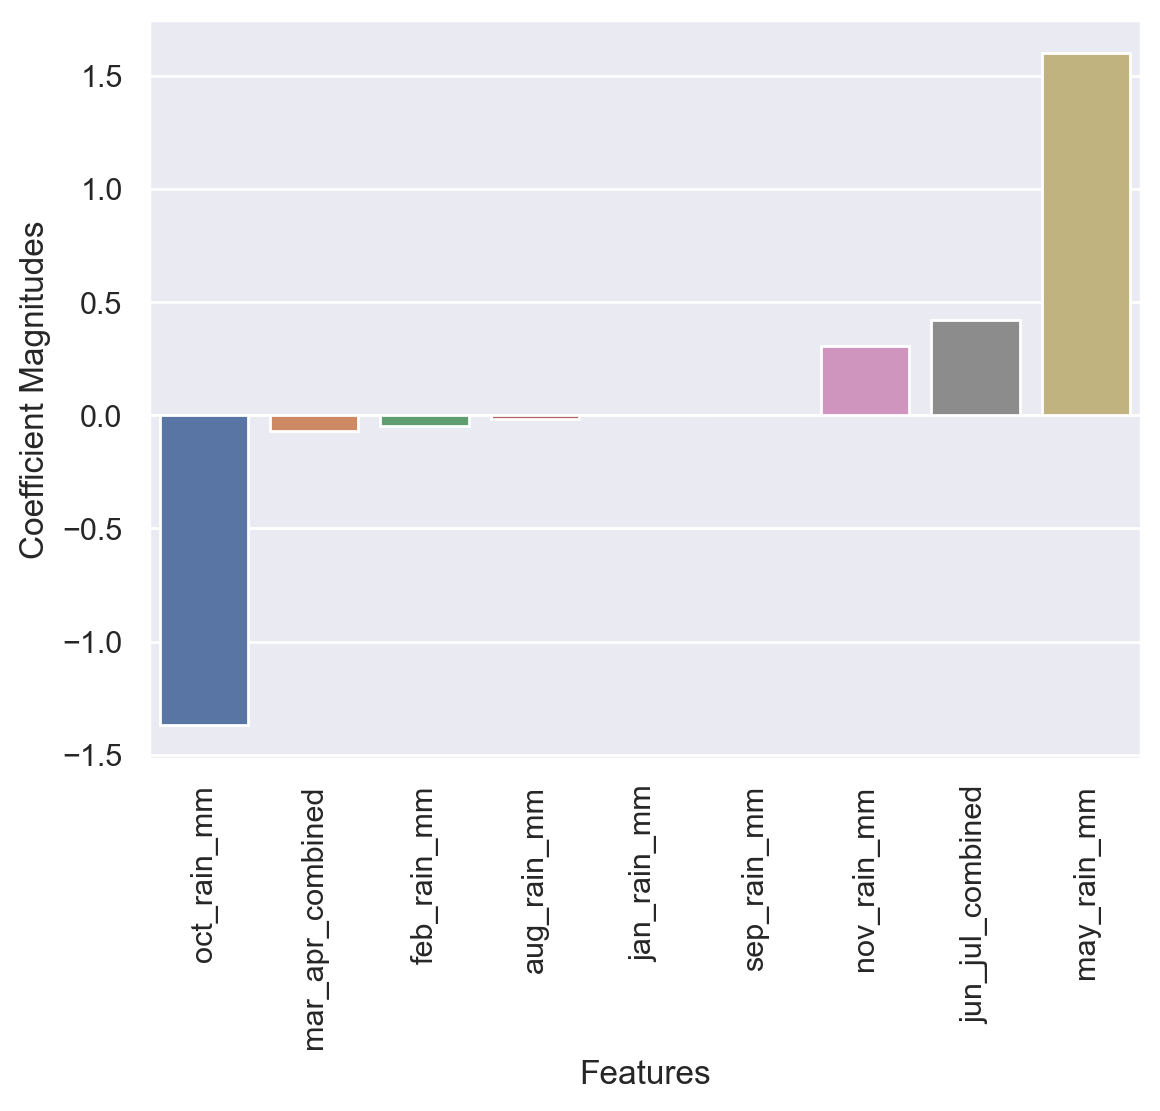

In [47]:
best_coefs = lr.best_estimator_.named_steps.lr.coef_[0]
sort_inds = np.argsort(best_coefs)

plt.figure(dpi=200)
sns.barplot(x=X.columns[sort_inds], y=best_coefs[sort_inds])
plt.ylabel('Coefficient Magnitudes')
plt.xlabel('Features')
plt.xticks(rotation=90);

LASSO has eliminated some features entirely or almost entirely. The important features appear to be May and October, where the higher the rainfall is in May and the lower the rainfall in October, the more likely the year will be profitable.

# Key Takeaway
A key takeaway from this is that if rainfall is low in the month of May, Cafe Casa Martinez should consider watering their crops using the free water they store in their cisterns. This is the only month where they rainfall is correlated with both production and profitability, so supplementing rainfall with irrigation when there is not enough will increase production and potentially save a year that would not otherwise be profitable. There are limits to this that the farmers are careful to be cognizant of. Too much rain will make the roots rot, which can kill a plant. May is the month where the rainfall averages peak, so irrigating if they already have a very wet month is a mistake they will not make.

In order to get a better idea of our auroc I'll now train a logistic regression model with the best parameters using k-fold cross validation with 10 folds.

In [49]:
models_lr, oof_preds_lr, fi_lr = kfold_model(LogisticRegression(C=best_params_lr['lr__C'],
                                                                penalty=best_params_lr['lr__penalty'],
                                                                solver=best_params_lr['lr__solver'],
                                                                max_iter=10_000),
                                             X, y)

############ Training FOLD 1 ############
############ Training FOLD 2 ############
############ Training FOLD 3 ############
############ Training FOLD 4 ############
############ Training FOLD 5 ############
############ Training FOLD 6 ############
############ Training FOLD 7 ############
############ Training FOLD 8 ############
############ Training FOLD 9 ############
############ Training FOLD 10 ############


Save the feature importances, or coefficient strengths.

In [50]:
fi_lr = pd.DataFrame(data=fi_lr).transpose()

In [51]:
fi_lr_mean = pd.DataFrame(fi_lr.mean(axis=1), columns=['mean'])
fi_lr_sem = pd.DataFrame(fi_lr.sem(axis=1), columns=['sem'])
fi_lr = pd.merge(fi_lr_mean, fi_lr_sem, right_index=True, left_index=True)

              precision    recall  f1-score   support

       False       0.78      0.80      0.79       239
        True       0.82      0.80      0.81       276

    accuracy                           0.80       515
   macro avg       0.80      0.80      0.80       515
weighted avg       0.80      0.80      0.80       515



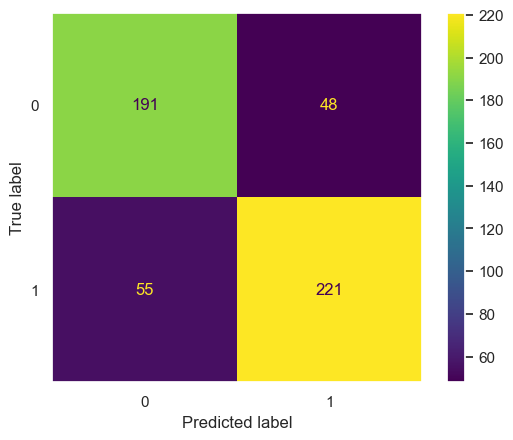

In [52]:
show_classification_reports(oof_preds_lr)

Our overall metrics are decent, but it would be better to find a model that can do better. Below I also plot the mean coefficient weights with the standard errors on those means. We see that the coefficients are stable across all folds because the standard errors are small. October and May are again our important features. 

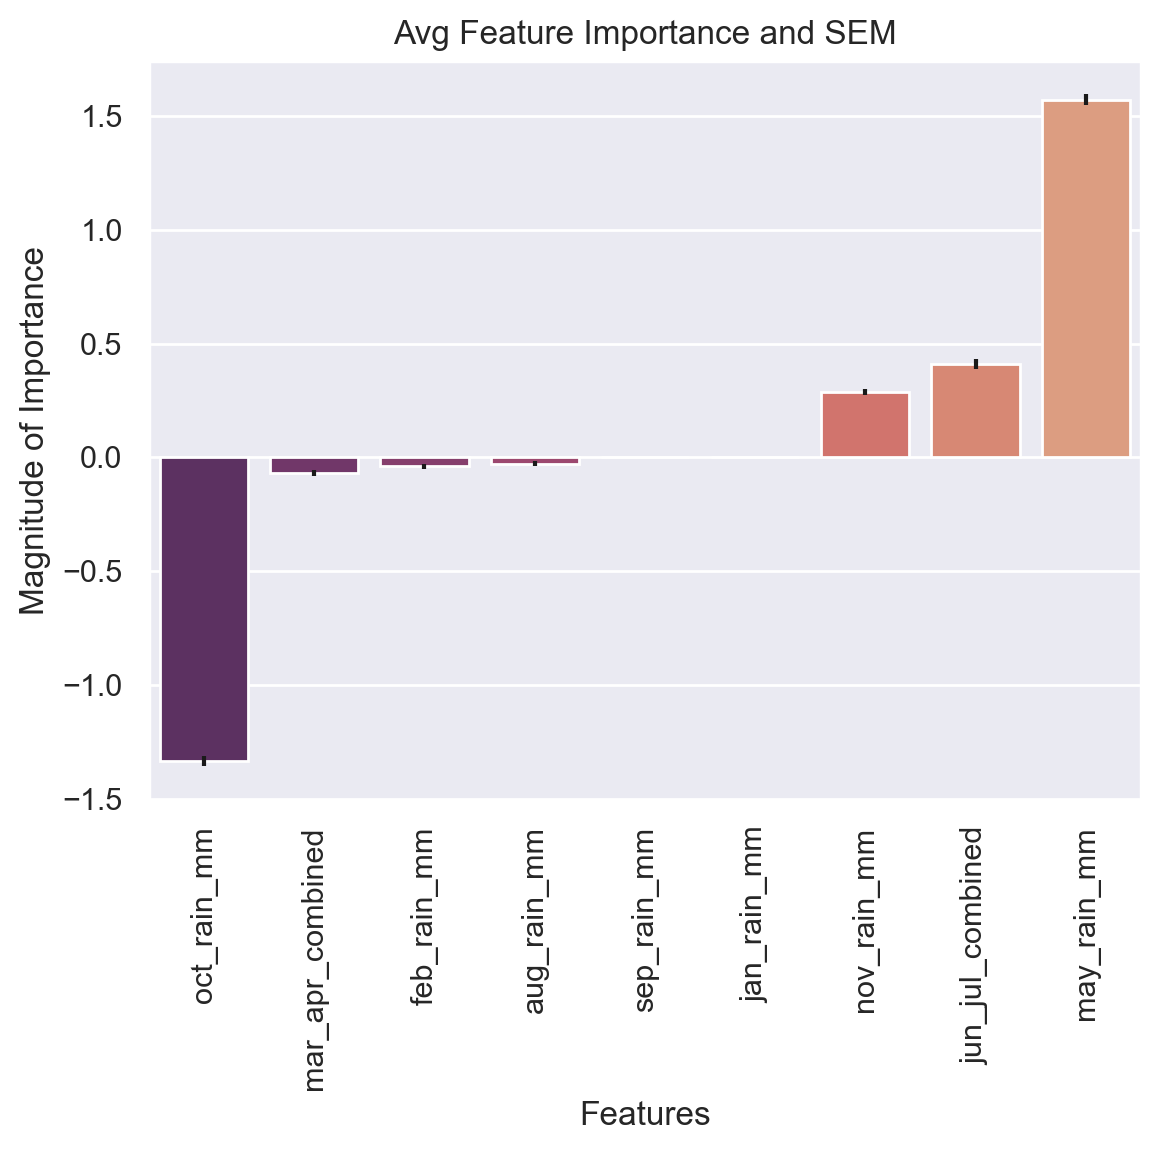

In [54]:
feature_importances_plot(fi_lr)

# Light GBM

Next I will try to fit a Light GBM classifier model using Optuna to search for the best hyperparameters. 

In [55]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng.integers(100, 10_000))
    dtrain = lgb.Dataset(X_train, label=y_train)
    
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000), 
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    
    roc_score = roc_auc_score(y_test, preds)
    
    return roc_score

In [56]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-02-23 10:13:58,145] A new study created in memory with name: no-name-39479e6b-7260-4dcc-9c44-3e13cc93ea4c
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:13:58,258] Trial 0 finished with value: 0.8430096763430096 and parameters: {'n_estimators': 970, 'learning_rate': 0.009709757910578279, 'lambda_l1': 0.001630987978829729, 'lambda_l2': 0.0887785822773633, 'num_leaves': 225, 'max_depth': 23, 'feature_fraction': 0.6833407437933596, 'bagging_fraction': 0.6494956703479335, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 0 with value: 0.8430096763430096.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I

[I 2023-02-23 10:14:00,582] Trial 12 finished with value: 0.8494838494838495 and parameters: {'n_estimators': 719, 'learning_rate': 0.03376452100387271, 'lambda_l1': 6.523294985284718e-05, 'lambda_l2': 6.458037480985147e-06, 'num_leaves': 97, 'max_depth': 78, 'feature_fraction': 0.9920605953467738, 'bagging_fraction': 0.8087313697059427, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 2 with value: 0.8897401732178547.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:00,945] Trial 13 finished with value: 0.8942074228234478 and parameters: {'n_estimators': 1202, 'learning_rate': 0.028885637438805685, 'lambda_l1': 0.33507032156433425, 'lambda_l2': 0.00047339182684096775, 'num_leaves': 31, 'max_depth': 75, 'feature_fraction': 0.8336844583956279, 'bagging_fraction': 0.7676860945743473,

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:03,992] Trial 25 finished with value: 0.9097920858484239 and parameters: {'n_estimators': 1639, 'learning_rate': 0.014393267866440098, 'lambda_l1': 0.0005425001704284173, 'lambda_l2': 0.00027003832414582455, 'num_leaves': 119, 'max_depth': 59, 'feature_fraction': 0.7984747610056999, 'bagging_fraction': 0.7762568181119646, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 25 with value: 0.9097920858484239.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:04,347] Trial 26 finished with value: 0.857095046854083 and parameters: {'n_estimators':

[I 2023-02-23 10:14:07,212] Trial 37 finished with value: 0.8854700854700854 and parameters: {'n_estimators': 1699, 'learning_rate': 0.018744929968697862, 'lambda_l1': 0.0021160763571257237, 'lambda_l2': 0.03420916317579632, 'num_leaves': 55, 'max_depth': 84, 'feature_fraction': 0.6920726333791071, 'bagging_fraction': 0.9087272574802306, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 25 with value: 0.9097920858484239.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:07,432] Trial 38 finished with value: 0.8531865198531865 and parameters: {'n_estimators': 1318, 'learning_rate': 0.007795811785744542, 'lambda_l1': 0.08753387400271948, 'lambda_l2': 0.008932675429819714, 'num_leaves': 74, 'max_depth': 72, 'feature_fraction': 0.850014610501556, 'bagging_fraction': 0.9588848859880061, '

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:10,377] Trial 50 finished with value: 0.8634984833164813 and parameters: {'n_estimators': 1270, 'learning_rate': 0.03875805832862398, 'lambda_l1': 1.3339482158953897, 'lambda_l2': 2.326743969400698e-07, 'num_leaves': 45, 'max_depth': 59, 'feature_fraction': 0.8946654045977018, 'bagging_fraction': 0.7392057873081286, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 25 with value: 0.9097920858484239.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:10,764] Trial 51 finished with value: 0.8449966193373901 and parameters: {'n_estimators': 1695

[I 2023-02-23 10:14:15,946] Trial 62 finished with value: 0.7914529914529914 and parameters: {'n_estimators': 1910, 'learning_rate': 0.02453204734014682, 'lambda_l1': 0.0019917770002798054, 'lambda_l2': 0.004266970765326135, 'num_leaves': 170, 'max_depth': 14, 'feature_fraction': 0.7703550861209959, 'bagging_fraction': 0.9175838189831922, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 25 with value: 0.9097920858484239.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:16,383] Trial 63 finished with value: 0.8293172690763052 and parameters: {'n_estimators': 1999, 'learning_rate': 0.022092246810865676, 'lambda_l1': 0.0005306759655511875, 'lambda_l2': 0.0003431955484903729, 'num_leaves': 189, 'max_depth': 83, 'feature_fraction': 0.8247707311158251, 'bagging_fraction': 0.77478750719633

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:22,082] Trial 75 finished with value: 0.857 and parameters: {'n_estimators': 1667, 'learning_rate': 0.02601972205382599, 'lambda_l1': 0.09708311126337012, 'lambda_l2': 0.0015791319475197566, 'num_leaves': 83, 'max_depth': 86, 'feature_fraction': 0.8058465234977208, 'bagging_fraction': 0.8258843345559522, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:22,609] Trial 76 finished with value: 0.8291624958291625 and parameters: {'n_estimators': 1026, 'learning_

[I 2023-02-23 10:14:26,984] Trial 87 finished with value: 0.8715382048715382 and parameters: {'n_estimators': 878, 'learning_rate': 0.03598301028547815, 'lambda_l1': 0.0010262292278859532, 'lambda_l2': 0.00024636034602831694, 'num_leaves': 39, 'max_depth': 30, 'feature_fraction': 0.8415692796798273, 'bagging_fraction': 0.7585496563153322, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:27,398] Trial 88 finished with value: 0.8194536975349767 and parameters: {'n_estimators': 1050, 'learning_rate': 0.032589288006084266, 'lambda_l1': 0.01675437447324154, 'lambda_l2': 0.00012733833934271415, 'num_leaves': 119, 'max_depth': 93, 'feature_fraction': 0.8036790519958409, 'bagging_fraction': 0.773779120402629

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:32,155] Trial 100 finished with value: 0.8858858858858858 and parameters: {'n_estimators': 1688, 'learning_rate': 0.03482940272440069, 'lambda_l1': 0.9453144528519973, 'lambda_l2': 0.0011095493427647847, 'num_leaves': 49, 'max_depth': 73, 'feature_fraction': 0.7658052542588486, 'bagging_fraction': 0.9515028847129349, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:32,742] Trial 101 finished with value: 0.840878604963112 and parameters: {'n_estimators': 1823

[I 2023-02-23 10:14:36,761] Trial 112 finished with value: 0.8441775108441776 and parameters: {'n_estimators': 1078, 'learning_rate': 0.037914935501150056, 'lambda_l1': 0.016047998128199608, 'lambda_l2': 2.9135398885144023e-05, 'num_leaves': 218, 'max_depth': 56, 'feature_fraction': 0.7458752089649943, 'bagging_fraction': 0.7682965781909872, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:37,000] Trial 113 finished with value: 0.8671666666666666 and parameters: {'n_estimators': 1264, 'learning_rate': 0.04048290159672906, 'lambda_l1': 0.038390100106076276, 'lambda_l2': 0.00011744433722834704, 'num_leaves': 200, 'max_depth': 70, 'feature_fraction': 0.7245198245490401, 'bagging_fraction': 0.9271934867

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:41,574] Trial 125 finished with value: 0.8668668668668669 and parameters: {'n_estimators': 905, 'learning_rate': 0.03380289026429645, 'lambda_l1': 0.0006241245778996103, 'lambda_l2': 0.000353026975468577, 'num_leaves': 149, 'max_depth': 45, 'feature_fraction': 0.8236653840133938, 'bagging_fraction': 0.8459256278233228, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:42,187] Trial 126 finished with value: 0.8222669349429913 and parameters: {'n_estimators': 

[I 2023-02-23 10:14:47,621] Trial 137 finished with value: 0.9020652898067955 and parameters: {'n_estimators': 953, 'learning_rate': 0.03043953314046096, 'lambda_l1': 0.00027871372084777577, 'lambda_l2': 0.0006413576126971008, 'num_leaves': 176, 'max_depth': 96, 'feature_fraction': 0.8352719824150256, 'bagging_fraction': 0.9462124844670992, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:48,038] Trial 138 finished with value: 0.8518518518518517 and parameters: {'n_estimators': 965, 'learning_rate': 0.030392165884654748, 'lambda_l1': 0.00028574291660993126, 'lambda_l2': 0.0010109073395917925, 'num_leaves': 186, 'max_depth': 97, 'feature_fraction': 0.8280149074056571, 'bagging_fraction': 0.9474098684

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:53,444] Trial 150 finished with value: 0.867045858514042 and parameters: {'n_estimators': 1749, 'learning_rate': 0.029905570386468114, 'lambda_l1': 0.0005677108698599958, 'lambda_l2': 0.0026716423774114464, 'num_leaves': 154, 'max_depth': 98, 'feature_fraction': 0.8845038449893237, 'bagging_fraction': 0.9140739385254227, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:53,921] Trial 151 finished with value: 0.8547523427041499 and parameters: {'n_estimators':

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:57,977] Trial 163 finished with value: 0.8534999999999999 and parameters: {'n_estimators': 613, 'learning_rate': 0.0429419608479758, 'lambda_l1': 0.5486151088589342, 'lambda_l2': 0.004291012878969592, 'num_leaves': 226, 'max_depth': 73, 'feature_fraction': 0.9824318295080197, 'bagging_fraction': 0.7545337332481492, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:14:58,273] Trial 164 finished with value: 0.8606091030789825 and parameters: {'n_estimators': 739,

[I 2023-02-23 10:15:01,190] Trial 175 finished with value: 0.8602744310575636 and parameters: {'n_estimators': 955, 'learning_rate': 0.029045152727976028, 'lambda_l1': 0.11100644062189235, 'lambda_l2': 7.54668400016968e-05, 'num_leaves': 228, 'max_depth': 75, 'feature_fraction': 0.9625662607130893, 'bagging_fraction': 0.7714520455474149, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:15:01,487] Trial 176 finished with value: 0.8777481678880746 and parameters: {'n_estimators': 1055, 'learning_rate': 0.027168922011690418, 'lambda_l1': 0.5167267503081973, 'lambda_l2': 0.00025609591401524806, 'num_leaves': 222, 'max_depth': 58, 'feature_fraction': 0.7859649851932031, 'bagging_fraction': 0.754407452847448

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:15:05,272] Trial 188 finished with value: 0.8136134453781513 and parameters: {'n_estimators': 1866, 'learning_rate': 0.021053405019681906, 'lambda_l1': 0.21858597239368335, 'lambda_l2': 0.0011096785445812278, 'num_leaves': 62, 'max_depth': 77, 'feature_fraction': 0.8214398923727808, 'bagging_fraction': 0.7620397993387874, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 73 with value: 0.9146382691007438.
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-02-23 10:15:05,774] Trial 189 finished with value: 0.8914132976946209 and parameters: {'n_estimators': 

In [57]:
print('best auroc:', study.best_trial.value)

best auroc: 0.9146382691007438


In [58]:
best_params = study.best_trial.params
best_params

{'n_estimators': 1106,
 'learning_rate': 0.023389305560257524,
 'lambda_l1': 0.009346119738650278,
 'lambda_l2': 0.0056511801249125885,
 'num_leaves': 83,
 'max_depth': 89,
 'feature_fraction': 0.776903939292123,
 'bagging_fraction': 0.7650647780383333,
 'bagging_freq': 2,
 'min_child_samples': 5}

The best trial's auroc is higher than that of our logistic regression model, but I still have to train the model using k-fold cross validation in order to get a fair estimate of our performance. Next I will train the model using k-fold cross validation and the best hyperparameters from Optuna.

In [59]:
models_lgbm, oof_preds_lgbm, fi_lgbm = kfold_lgbm(X, y, best_params, early_stopping_rounds=100, verbose=1)

############ Training FOLD 1 ############
[LightGBM] [Warning] feature_fraction is set=0.776903939292123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776903939292123
[LightGBM] [Warning] lambda_l1 is set=0.009346119738650278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009346119738650278
[LightGBM] [Warning] bagging_fraction is set=0.7650647780383333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7650647780383333
[LightGBM] [Warning] lambda_l2 is set=0.0056511801249125885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0056511801249125885
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's binary_logloss: 0.695039
[2]	valid_0's binary_logloss: 0.682363
[3]	valid_0's binary_logloss: 0.678963
[4]	valid_0's binary_logloss: 0.670257
[5]	valid_0's binary_logloss: 0.661721
[6]	valid_0's binary_logloss: 0.655322
[7]	valid_0's binary_logloss: 0.646055
[

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_r

[76]	valid_0's binary_logloss: 0.43124
[77]	valid_0's binary_logloss: 0.430115
[78]	valid_0's binary_logloss: 0.430433
[79]	valid_0's binary_logloss: 0.431463
[80]	valid_0's binary_logloss: 0.428469
[81]	valid_0's binary_logloss: 0.427824
[82]	valid_0's binary_logloss: 0.427554
[83]	valid_0's binary_logloss: 0.426917
[84]	valid_0's binary_logloss: 0.42689
[85]	valid_0's binary_logloss: 0.428283
[86]	valid_0's binary_logloss: 0.428215
[87]	valid_0's binary_logloss: 0.427017
[88]	valid_0's binary_logloss: 0.425419
[89]	valid_0's binary_logloss: 0.425074
[90]	valid_0's binary_logloss: 0.422825
[91]	valid_0's binary_logloss: 0.422331
[92]	valid_0's binary_logloss: 0.422056
[93]	valid_0's binary_logloss: 0.420772
[94]	valid_0's binary_logloss: 0.419918
[95]	valid_0's binary_logloss: 0.421123
[96]	valid_0's binary_logloss: 0.420834
[97]	valid_0's binary_logloss: 0.420693
[98]	valid_0's binary_logloss: 0.420716
[99]	valid_0's binary_logloss: 0.421774
[100]	valid_0's binary_logloss: 0.421004
[

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[81]	valid_0's binary_logloss: 0.456465
[82]	valid_0's binary_logloss: 0.455062
[83]	valid_0's binary_logloss: 0.454554
[84]	valid_0's binary_logloss: 0.45313
[85]	valid_0's binary_logloss: 0.451763
[86]	valid_0's binary_logloss: 0.453307
[87]	valid_0's binary_logloss: 0.451272
[88]	valid_0's binary_logloss: 0.449089
[89]	valid_0's binary_logloss: 0.448467
[90]	valid_0's binary_logloss: 0.448676
[91]	valid_0's binary_logloss: 0.449717
[92]	valid_0's binary_logloss: 0.446978
[93]	valid_0's binary_logloss: 0.444686
[94]	valid_0's binary_logloss: 0.441918
[95]	valid_0's binary_logloss: 0.439889
[96]	valid_0's binary_logloss: 0.439152
[97]	valid_0's binary_logloss: 0.437894
[98]	valid_0's binary_logloss: 0.434914
[99]	valid_0's binary_logloss: 0.432844
[100]	valid_0's binary_logloss: 0.433288
[101]	valid_0's binary_logloss: 0.430258
[102]	valid_0's binary_logloss: 0.430166
[103]	valid_0's binary_logloss: 0.428547
[104]	valid_0's binary_logloss: 0.427793
[105]	valid_0's binary_logloss: 0.42

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_r

[62]	valid_0's binary_logloss: 0.522531
[63]	valid_0's binary_logloss: 0.520657
[64]	valid_0's binary_logloss: 0.517843
[65]	valid_0's binary_logloss: 0.518766
[66]	valid_0's binary_logloss: 0.518652
[67]	valid_0's binary_logloss: 0.518633
[68]	valid_0's binary_logloss: 0.520382
[69]	valid_0's binary_logloss: 0.521135
[70]	valid_0's binary_logloss: 0.521591
[71]	valid_0's binary_logloss: 0.521067
[72]	valid_0's binary_logloss: 0.521091
[73]	valid_0's binary_logloss: 0.52066
[74]	valid_0's binary_logloss: 0.520142
[75]	valid_0's binary_logloss: 0.51898
[76]	valid_0's binary_logloss: 0.518711
[77]	valid_0's binary_logloss: 0.518645
[78]	valid_0's binary_logloss: 0.517313
[79]	valid_0's binary_logloss: 0.51787
[80]	valid_0's binary_logloss: 0.518357
[81]	valid_0's binary_logloss: 0.516145
[82]	valid_0's binary_logloss: 0.519151
[83]	valid_0's binary_logloss: 0.518356
[84]	valid_0's binary_logloss: 0.518475
[85]	valid_0's binary_logloss: 0.519177
[86]	valid_0's binary_logloss: 0.520364
[87

[109]	valid_0's binary_logloss: 0.404467
[110]	valid_0's binary_logloss: 0.40431
[111]	valid_0's binary_logloss: 0.403902
[112]	valid_0's binary_logloss: 0.404252
[113]	valid_0's binary_logloss: 0.400652
[114]	valid_0's binary_logloss: 0.400341
[115]	valid_0's binary_logloss: 0.40148
[116]	valid_0's binary_logloss: 0.400899
[117]	valid_0's binary_logloss: 0.40029
[118]	valid_0's binary_logloss: 0.400643
[119]	valid_0's binary_logloss: 0.400747
[120]	valid_0's binary_logloss: 0.402311
[121]	valid_0's binary_logloss: 0.403179
[122]	valid_0's binary_logloss: 0.401539
[123]	valid_0's binary_logloss: 0.400161
[124]	valid_0's binary_logloss: 0.399135
[125]	valid_0's binary_logloss: 0.39795
[126]	valid_0's binary_logloss: 0.397308
[127]	valid_0's binary_logloss: 0.397447
[128]	valid_0's binary_logloss: 0.398658
[129]	valid_0's binary_logloss: 0.398017
[130]	valid_0's binary_logloss: 0.398286
[131]	valid_0's binary_logloss: 0.397478
[132]	valid_0's binary_logloss: 0.398126
[133]	valid_0's bina

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_r

[114]	valid_0's binary_logloss: 0.484325
[115]	valid_0's binary_logloss: 0.483852
[116]	valid_0's binary_logloss: 0.485653
[117]	valid_0's binary_logloss: 0.4845
[118]	valid_0's binary_logloss: 0.480504
[119]	valid_0's binary_logloss: 0.481688
[120]	valid_0's binary_logloss: 0.483475
[121]	valid_0's binary_logloss: 0.483225
[122]	valid_0's binary_logloss: 0.48481
[123]	valid_0's binary_logloss: 0.485023
[124]	valid_0's binary_logloss: 0.484296
[125]	valid_0's binary_logloss: 0.484155
[126]	valid_0's binary_logloss: 0.485239
[127]	valid_0's binary_logloss: 0.483673
[128]	valid_0's binary_logloss: 0.483579
[129]	valid_0's binary_logloss: 0.48384
[130]	valid_0's binary_logloss: 0.484147
[131]	valid_0's binary_logloss: 0.483901
[132]	valid_0's binary_logloss: 0.484034
[133]	valid_0's binary_logloss: 0.485666
[134]	valid_0's binary_logloss: 0.488326
[135]	valid_0's binary_logloss: 0.488534
[136]	valid_0's binary_logloss: 0.486321
[137]	valid_0's binary_logloss: 0.487148
[138]	valid_0's bina

[175]	valid_0's binary_logloss: 0.367803
[176]	valid_0's binary_logloss: 0.366449
[177]	valid_0's binary_logloss: 0.366334
[178]	valid_0's binary_logloss: 0.365356
[179]	valid_0's binary_logloss: 0.365912
[180]	valid_0's binary_logloss: 0.364962
[181]	valid_0's binary_logloss: 0.364451
[182]	valid_0's binary_logloss: 0.362696
[183]	valid_0's binary_logloss: 0.363043
[184]	valid_0's binary_logloss: 0.363707
[185]	valid_0's binary_logloss: 0.362822
[186]	valid_0's binary_logloss: 0.363465
[187]	valid_0's binary_logloss: 0.363819
[188]	valid_0's binary_logloss: 0.36525
[189]	valid_0's binary_logloss: 0.364961
[190]	valid_0's binary_logloss: 0.36495
[191]	valid_0's binary_logloss: 0.365465
[192]	valid_0's binary_logloss: 0.366488
[193]	valid_0's binary_logloss: 0.367732
[194]	valid_0's binary_logloss: 0.36874
[195]	valid_0's binary_logloss: 0.368255
[196]	valid_0's binary_logloss: 0.367809
[197]	valid_0's binary_logloss: 0.368065
[198]	valid_0's binary_logloss: 0.367932
[199]	valid_0's bin

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_r

[9]	valid_0's binary_logloss: 0.600788
[10]	valid_0's binary_logloss: 0.594797
[11]	valid_0's binary_logloss: 0.588918
[12]	valid_0's binary_logloss: 0.582148
[13]	valid_0's binary_logloss: 0.571738
[14]	valid_0's binary_logloss: 0.564079
[15]	valid_0's binary_logloss: 0.557671
[16]	valid_0's binary_logloss: 0.554352
[17]	valid_0's binary_logloss: 0.550598
[18]	valid_0's binary_logloss: 0.543821
[19]	valid_0's binary_logloss: 0.536049
[20]	valid_0's binary_logloss: 0.52949
[21]	valid_0's binary_logloss: 0.525747
[22]	valid_0's binary_logloss: 0.522344
[23]	valid_0's binary_logloss: 0.51792
[24]	valid_0's binary_logloss: 0.514938
[25]	valid_0's binary_logloss: 0.510803
[26]	valid_0's binary_logloss: 0.506889
[27]	valid_0's binary_logloss: 0.5039
[28]	valid_0's binary_logloss: 0.501974
[29]	valid_0's binary_logloss: 0.498588
[30]	valid_0's binary_logloss: 0.496387
[31]	valid_0's binary_logloss: 0.491951
[32]	valid_0's binary_logloss: 0.487621
[33]	valid_0's binary_logloss: 0.485074
[34]	

[LightGBM] [Warning] feature_fraction is set=0.776903939292123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776903939292123
[LightGBM] [Warning] lambda_l1 is set=0.009346119738650278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009346119738650278
[LightGBM] [Warning] bagging_fraction is set=0.7650647780383333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7650647780383333
[LightGBM] [Warning] lambda_l2 is set=0.0056511801249125885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0056511801249125885
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's binary_logloss: 0.695017
[2]	valid_0's binary_logloss: 0.688275
[3]	valid_0's binary_logloss: 0.684123
[4]	valid_0's binary_logloss: 0.675866
[5]	valid_0's binary_logloss: 0.670253
[6]	valid_0's binary_logloss: 0.664882
[7]	valid_0's binary_logloss: 0.659333
[8]	valid_0's binary_logloss: 0.654411
[9]	

F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
F:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [61]:
fi_lgbm = avg_fi(fi_lgbm)

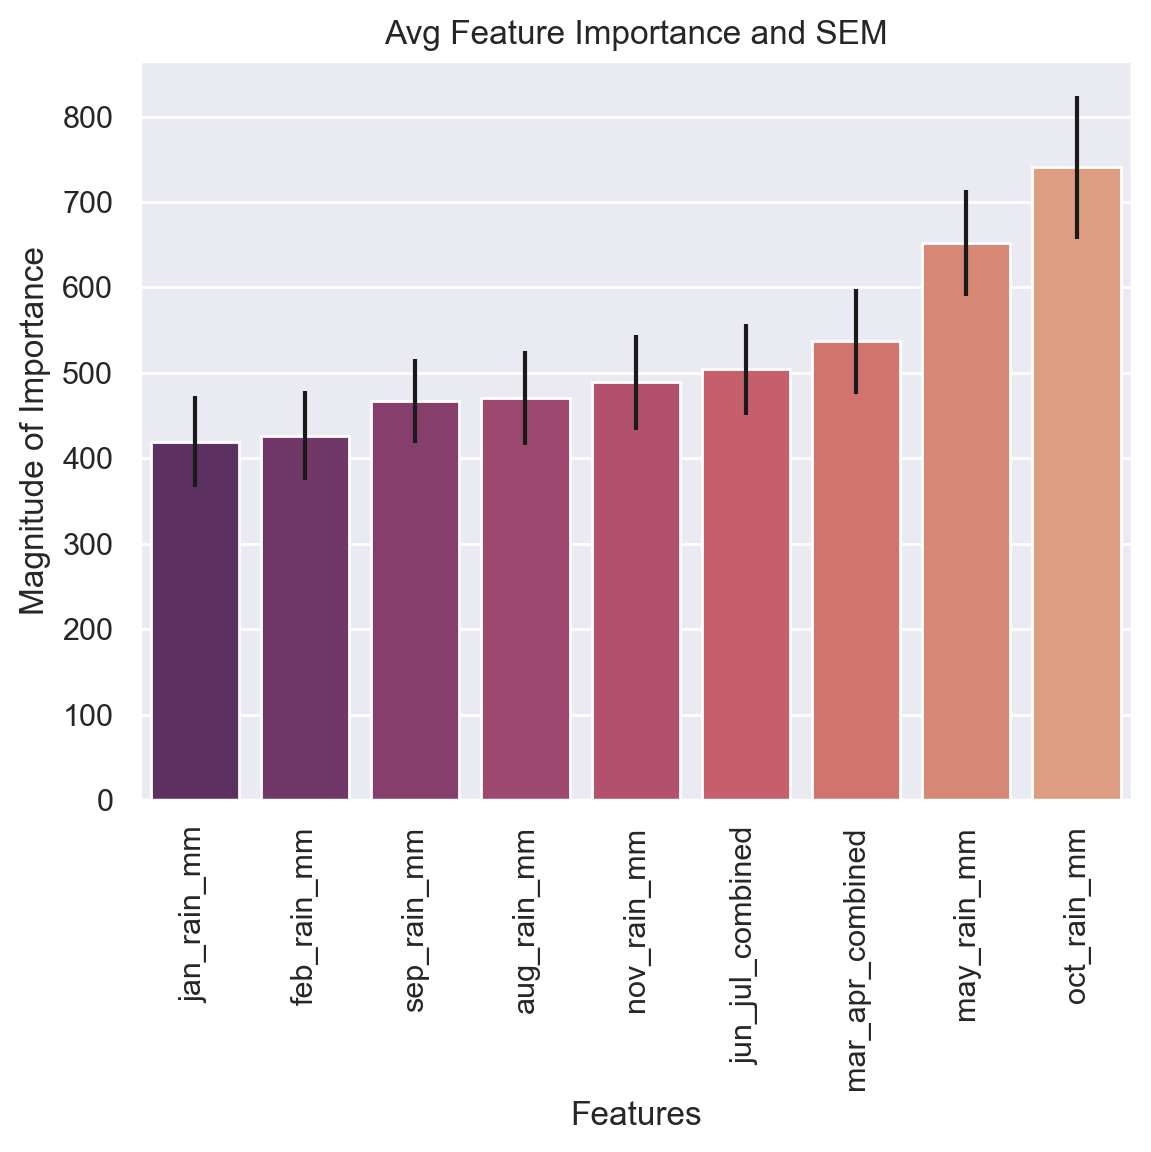

In [62]:
feature_importances_plot(fi_lgbm)

May and October are again the most important features, followed by March and April. The feature importances are a lot closer with LGBM and the standard errors on the means are a lot larger than they were with logistic regression, meaning the variation in importances is higher across all the folds. Note that these are magnitudes of importance rather than positive or negative coefficients. October and May are both important, but there is no indication that lower rainfall in October is better, which is still surely the case. This is the advantage of running logistic regression as well since it gave us that insight.

              precision    recall  f1-score   support

       False       0.76      0.73      0.74       239
        True       0.77      0.80      0.78       276

    accuracy                           0.77       515
   macro avg       0.76      0.76      0.76       515
weighted avg       0.76      0.77      0.76       515



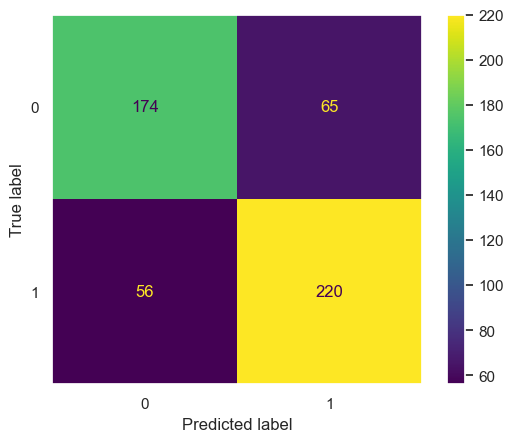

In [64]:
show_classification_reports(oof_preds_lgbm)

Here the classification report shows slightly lower scores across the board than logistic regression. Next I will compare the AUROC for our two models.

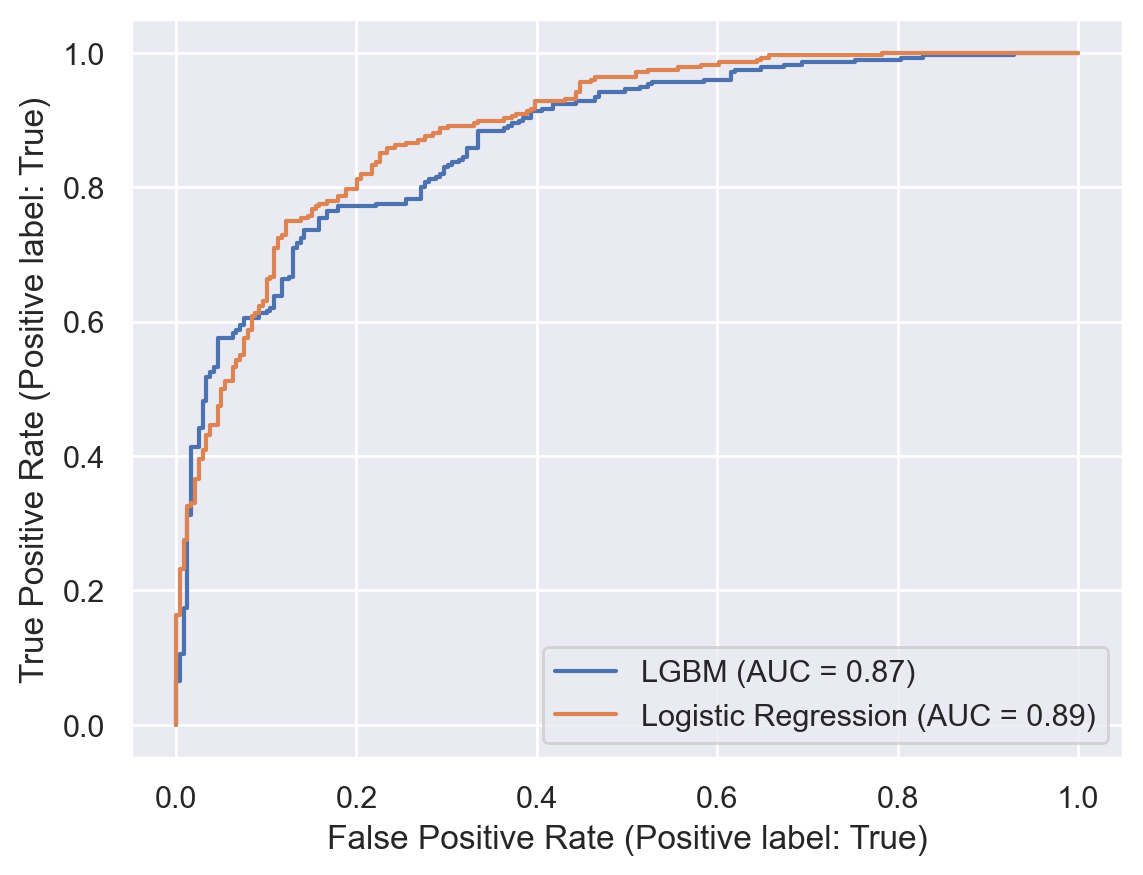

In [65]:
fig, ax = plt.subplots(dpi=200)
RocCurveDisplay.from_predictions(oof_preds_lgbm.y_true, oof_preds_lgbm.preds, ax=ax, name='LGBM', pos_label=True);
RocCurveDisplay.from_predictions(oof_preds_lr.y_true, oof_preds_lr.preds, ax=ax, name='Logistic Regression', pos_label=True);

Logistic regression has a higher area under the curve, but these curves also cross, so depending on the rounding threshold we choose for prediciton of profitability LGBM may still be a better model.

# Probability Thresholds

I have shown that having higher rain during the month of May is correlated with more coffee production. This was the only month with a statistically significant positive correlation between rainfall and production. While an irrigation system for the whole farm would be prohibitively expensive, Cafe Casa Martinez has access to a moderate amount of free water in the form of  rainfall collection cisterns. I recommend elsewhere that if rainfall is low during the month of May they should use this collected rainwater to water their crops because it may turn an unprofitable season into a profitable one. 

We would rather avoid false positive predictions about whether a year will be profitable because the downside for a false positive is that you do not water the plants when they needed it and therefore they don't produce enough. The downside for a false negative is that you simply increase the production by increasing the water each plant has access to. There is a limit to this, in that overwatering plants can cause the roots to rot, leading to decreased production. The farmers are acutely aware that they should not water plants just because our model recommends it if they are at risk of being over-watered.

The farm is willing to accept a 10% false positive rate, so next I will find the thresholds that correspond to that false positive rate.

In [84]:
oof_preds_lgbm.columns

Index(['data_ind', 'preds', 'y_true'], dtype='object')

In [85]:
# calculate true and false positive rates at a range of thresholds
thr_lr = thresholds(oof_preds_lr.y_true, oof_preds_lr.preds, pos_label=True)
thr_lgbm = thresholds(oof_preds_lgbm.y_true, oof_preds_lgbm.preds, pos_label=True)

In [90]:
thr_lr.loc[40:50]

,tpr,fpr,thresh
40,0.612319,0.087866,0.693193
41,0.612319,0.092050,0.691881
42,0.623188,0.092050,0.687381
43,0.623188,0.096234,0.684541
44,0.630435,0.096234,0.683671
45,0.630435,0.100418,0.681440
46,0.663043,0.100418,0.656700
47,0.663043,0.104603,0.656549
48,0.666667,0.104603,0.653554
49,0.666667,0.108787,0.653090


In [92]:
thr_lgbm.loc[30:40]

,tpr,fpr,thresh
30,0.605072,0.075314,0.778061
31,0.605072,0.092050,0.770939
32,0.612319,0.092050,0.765450
33,0.612319,0.100418,0.762243
34,0.615942,0.100418,0.762031
35,0.615942,0.104603,0.760376
36,0.619565,0.104603,0.758753
37,0.619565,0.108787,0.756441
38,0.637681,0.108787,0.746555
39,0.637681,0.117155,0.738253


# Key takeaway
- Logistic regression has a 63% tpr and 10% fpr using a threshold of 0.68
- lgbm has a 61% tpr and 10% fpr, using a threshold of 0.76

In this case, logistic regression is the model we will proceed with because it maximizes the true positive rate at a fixed false positive rate of 10%. Finally I will retrain the logistic regression model on all the data using the best hyperparameters and then I'll save the model for use in the dashboard.

In [93]:
lr_final = LogisticRegression(C=best_params_lr['lr__C'],
                              penalty=best_params_lr['lr__penalty'],
                              solver=best_params_lr['lr__solver'],
                              max_iter=10_000)

In [95]:
sca = StandardScaler()
X_sca = sca.fit_transform(X)

In [96]:
lr_final.fit(X_sca, y)

LogisticRegression(C=0.17448294339374884, max_iter=10000, penalty='l1',
                   solver='liblinear')

In [98]:
if SAVE_DATA is True:
    sf.to_parquet(SIM_DATA_PATH)

if SAVE_MODEL is True:
    dump(lr_final, MODEL_PATH)